## Preprocessing CPS Fertility Data

This notebook preprocesses the CPS fertility data, including resampling, and compares it with Census historical data.

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/BayesFertility/raw/main/utils.py")

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate, value_counts, resample_rows_weighted, round_into_bins
import os

In [3]:
# Make the figures smaller to save some screen real estate.
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6.75, 3.5]


## Data

IPUMS CPS, University of Minnesota, www.ipums.org

> Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, J. Robert Warren, Daniel Backman, Annie Chen, Grace Cooper, Stephanie Richards, Megan Schouweiler, and Michael Westberry. IPUMS CPS: Version 12.0 [dataset]. Minneapolis, MN: IPUMS, 2024. https://doi.org/10.18128/D030.V12.0 


Extract 13 from https://cps.ipums.org/cps-action/data_requests/download

2025-Dec-02

29 Samples: June 1976 to June 2024

17 Variables

In [4]:
# I can't redistribute the data

# download(
#    "https://github.com/AllenDowney/BayesFertility/raw/refs/heads/main/cps_00013.dta.gz"
# )

In [5]:
df_all = pd.read_stata("../data/cps_00013.dta.gz", convert_categoricals=False)
df_all.head()

,year,serial,month,hwtfinl,cpsid,pernum,wtfinl,cpsidv,cpsidp,age,sex,race,marst,frever,frage1,frbirthy1,frsuppwt
0,1976,1,6,NaN,1.976050e+13,1,1619.42,1.976050e+14,1.976050e+13,24,1,100,1,999,NaN,NaN,1619.42
1,1976,1,6,NaN,1.976050e+13,2,1436.61,1.976050e+14,1.976050e+13,19,2,100,1,0,NaN,NaN,1436.61
2,1976,2,6,NaN,1.976050e+13,1,1522.36,1.976050e+14,1.976050e+13,48,1,100,1,999,NaN,NaN,1522.36
3,1976,2,6,NaN,1.976050e+13,2,1614.59,1.976050e+14,1.976050e+13,45,2,100,1,3,NaN,NaN,1614.59
4,1976,2,6,NaN,1.976050e+13,3,1365.79,1.976050e+14,1.976050e+13,16,2,100,6,0,NaN,NaN,1365.79


In [6]:
df_all.columns

Index(['year', 'serial', 'month', 'hwtfinl', 'cpsid', 'pernum', 'wtfinl',
       'cpsidv', 'cpsidp', 'age', 'sex', 'race', 'marst', 'frever', 'frage1',
       'frbirthy1', 'frsuppwt'],
      dtype='object')

In [7]:
df_all.shape

(3913169, 17)

In [8]:
value_counts(df_all["sex"])

,counts
values,
1,1887867
2,2025302


In [9]:
value_counts(df_all["frever"])

,counts
values,
0,394922
1,164067
2,224842
3,125344
4,55818
5,24398
6,9922
7,4856
8,2797


In [10]:
df_all["parity"] = df_all["frever"].replace(999, np.nan)
value_counts(df_all["parity"])

,counts
values,
0.0,394922
1.0,164067
2.0,224842
3.0,125344
4.0,55818
5.0,24398
6.0,9922
7.0,4856
8.0,2797


In [11]:
df_all['wtfinl'].describe()

count    3.913169e+06
mean     1.962106e+03
std      1.226900e+03
min      0.000000e+00
25%      1.137340e+03
50%      1.751660e+03
75%      2.611542e+03
max      4.334756e+04
Name: wtfinl, dtype: float64

In [12]:
df_all['frsuppwt'].describe()

count    3.913169e+06
mean     1.962106e+03
std      1.226900e+03
min      0.000000e+00
25%      1.137340e+03
50%      1.751660e+03
75%      2.611542e+03
max      4.334756e+04
Name: frsuppwt, dtype: float64

In [13]:
df_all["cohort"] = df_all["year"] - df_all["age"]
value_counts(df_all['cohort'])

,counts
values,
1877,4
1878,9
1879,10
1880,20
1881,23
...,...
2020,2866
2021,2020
2022,1885


In [14]:
value_counts(df_all['year'])

,counts
values,
1976,99240
1977,116960
1979,148018
1980,173221
1981,156913
1982,156398
1983,154694
1984,152669
1986,150686


I'll put respondents into groups by year of birth and age when they were interviewed.
In both dimensions, the width of the bins is three years.
The label on each bin is the midpoint.

In [15]:
df_all["age"].describe()

count    3.913169e+06
mean     3.625805e+01
std      2.245104e+01
min      0.000000e+00
25%      1.700000e+01
50%      3.400000e+01
75%      5.400000e+01
max      9.900000e+01
Name: age, dtype: float64

In [16]:
df_all["age_group"] = round_into_bins(df_all["age"], 3, low=14) + 1

In [17]:
df_all.groupby("age_group")["age"].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
15.0,184012.0,15.008815,0.816748,14.0,14.0,15.0,16.0,16.0
18.0,178013.0,17.966845,0.815428,17.0,17.0,18.0,19.0,19.0
21.0,166106.0,21.000187,0.814719,20.0,20.0,21.0,22.0,22.0
24.0,170472.0,24.008412,0.817812,23.0,23.0,24.0,25.0,25.0
27.0,173074.0,27.004437,0.816980,26.0,26.0,27.0,28.0,28.0
30.0,177556.0,29.995331,0.813875,29.0,29.0,30.0,31.0,31.0
33.0,174570.0,32.992805,0.815597,32.0,32.0,33.0,34.0,34.0
36.0,169256.0,35.986901,0.818005,35.0,35.0,36.0,37.0,37.0
39.0,162481.0,39.001729,0.817485,38.0,38.0,39.0,40.0,40.0


In [18]:
df_all["birth_group"] = round_into_bins(df_all["cohort"], 3, low=1) + 1

In [19]:
df_all.groupby("birth_group")["cohort"].describe()

,count,mean,std,min,25%,50%,75%,max
birth_group,,,,,,,,
1877.0,13.0,1877.692308,0.480384,1877.0,1877.0,1878.0,1878.0,1878.0
1880.0,53.0,1880.245283,0.757162,1879.0,1880.0,1880.0,1881.0,1881.0
1883.0,278.0,1883.287770,0.781044,1882.0,1883.0,1883.0,1884.0,1884.0
1886.0,684.0,1886.143275,0.806234,1885.0,1885.0,1886.0,1887.0,1887.0
1889.0,1674.0,1889.236559,0.800598,1888.0,1889.0,1889.0,1890.0,1890.0
1892.0,3381.0,1892.149364,0.811086,1891.0,1891.0,1892.0,1893.0,1893.0
1895.0,6124.0,1895.192195,0.810150,1894.0,1894.0,1895.0,1896.0,1896.0
1898.0,10146.0,1898.056475,0.805026,1897.0,1897.0,1898.0,1899.0,1899.0
1901.0,15501.0,1901.051481,0.814027,1900.0,1900.0,1901.0,1902.0,1902.0


## Compare with Census data

We'll compare the CFR computed from our CPS data with historical Census data to validate our preprocessing.

The data is from:
https://www2.census.gov/programs-surveys/demo/tables/fertility/time-series/his-cps/h2.xlsx

I have selected the data for women 40-44 and put the results in a csv file.

In [20]:
h2 = pd.read_csv('../data/h2.csv', index_col='Year', thousands=',')
h2.head()

,Total,Rate
Year,,
2024,10946,1918
2022,10629,1913
2020,10144,1994
2018,9896,2036
2016,9924,2068


In [21]:
cfr_h2 = h2['Rate'] / 1000
cfr_h2.head()

Year
2024    1.918
2022    1.913
2020    1.994
2018    2.036
2016    2.068
Name: Rate, dtype: float64

In [22]:
# Compute weighted CFR from our CPS data for women age 40-45
weight_col = 'frsuppwt'
df_cfr = df_all.query("age >= 40 and age <45").dropna(subset=['parity'])

# Compute weighted mean by year
def weighted_mean(group):
    return np.average(group['parity'], weights=group[weight_col])

cfr_cps = df_cfr.groupby("year").apply(weighted_mean, include_groups=False)

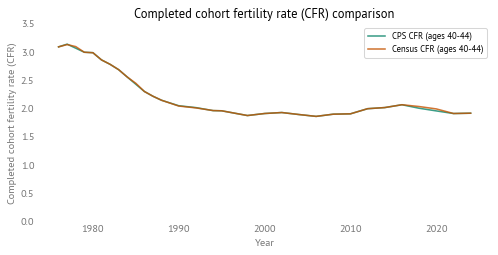

In [23]:
# Compare CPS data with Census data
cfr_cps.plot(label="CPS CFR (ages 40-44)", alpha=0.8)
cfr_h2.plot(alpha=0.8, label="Census CFR (ages 40-44)")
decorate(
    title="Completed cohort fertility rate (CFR) comparison",
    ylabel="Completed cohort fertility rate (CFR)",
    ylim=[0, 3.5]
)

## Filtering

First, let's drop people older than 54, who don't contribute much information about fertility.

Next, to validate past predictions, we'll restrict data based on survey year.

In [24]:
survey_years = df_all['year'].unique()
survey_years

array([1976, 1977, 1979, 1980, 1981, 1982, 1983, 1984, 1986, 1987, 1988,
       1990, 1992, 1994, 1995, 1998, 2000, 2002, 2004, 2006, 2008, 2010,
       2012, 2014, 2016, 2018, 2020, 2022, 2024], dtype=int16)

In [25]:
cutoff_year = 2024
df = df_all.query('sex == 2 and age_group <= 54 and year <= @cutoff_year').copy()
df.shape

(1168265, 21)

## Resampling

https://cps.ipums.org/cps/fertility_sample_notes.shtml

"FRSUPPWT should be used to tally the Fertility and Marriage supplement. This weight is identical to the basic survey sample weights."

In [26]:
df['weight'] = df['frsuppwt'] / df['frsuppwt'].mean()

In [27]:
df[["frsuppwt", 'weight']].describe()

,frsuppwt,weight
count,1.168265e+06,1.168265e+06
mean,1.959016e+03,1.000000e+00
std,1.205449e+03,6.153340e-01
min,0.000000e+00,0.000000e+00
25%,1.169227e+03,5.968441e-01
50%,1.747520e+03,8.920398e-01
75%,2.578269e+03,1.316104e+00
max,2.619413e+04,1.337107e+01


In [28]:
# Set random seed for reproducibility
np.random.seed(17)

weight_col = 'weight'
sample = resample_rows_weighted(df, weight_col)

In [29]:
sample.groupby('year')[['cohort', 'parity']].count()

,cohort,parity
year,,
1976,31906,31788
1977,32805,29008
1979,33303,33303
1980,34484,33608
1981,34943,34038
1982,35180,34324
1983,35602,34706
1984,35522,25432
1986,37034,26769


To see whether the resampling makes much of a difference, we'll compute the mean of `parity` in each age group and birth group, and compare the results with and without resampling.

In [30]:
def compare_parity(df, sample, col):
    unsampled = df.groupby(col)["parity"].mean()
    sampled = sample.groupby(col)["parity"].mean()

    unsampled.plot(label="unsampled")
    sampled.plot(label="sampled")
    decorate(ylabel="Mean parity")

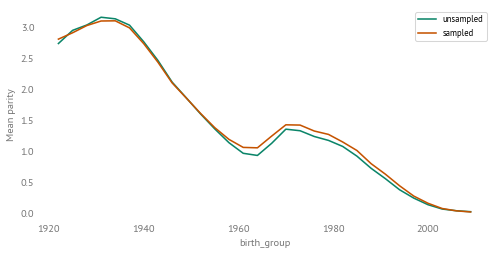

In [31]:
compare_parity(df, sample, "birth_group")

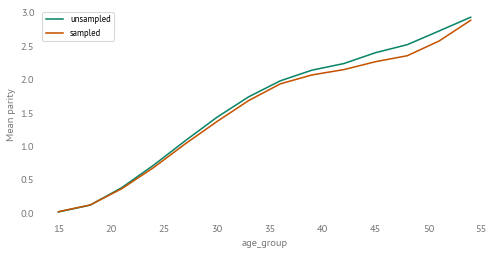

In [32]:
compare_parity(df, sample, "age_group")

Across birth groups and age groups, the differences in average parity -- with and without resampling -- are non-negligible.
So we'll need to take the sampling design into account.

## Prepare the data

The following function takes a `DataFrame` and returns aggregated parity data in the form we need for inference: `count_df` contains the number of women in each age-cohort group, and `sum_df` reports the total parity of all women in each group.

In [33]:
def prepare_data(df, weight_col='', weighted=False):
    """Prepares aggregated parity data.

    df: DataFrame containing 'birth_group', 'age_group', 'parity', and weight_col.
    weight_col: string column name
    weighted: bool, whether to weight the parity values by 'finalwgt'.

    Returns:
        sum_df: DataFrame with weighted sum of parity per cohort.
        count_df: DataFrame with count of parity observations per cohort.
    """
    if weighted:
        weights = df[weight_col] / df[weight_col].mean()
        df["weighted_parity"] = df["parity"] * weights
    else:
        df["weighted_parity"] = df["parity"]

    # Aggregate weighted sum and weighted count at birth_group and age_group level
    table = (
        df.groupby(["birth_group", "age_group"])["weighted_parity"]
        .agg(["sum", "count"])
        .unstack()
    )

    # Create a shared cohort index
    # cohort_labels = [1900 + cohort for cohort in table.index]
    cohort_index = table.index

    # Create sum and count tables with the shared index
    sum_df = table["sum"].set_index(cohort_index)
    count_df = table["count"].fillna(0).set_index(cohort_index)

    return sum_df, count_df

Here are the results for the unweighted and resampled data. 

In [34]:
sum_df_unweighted, count_df_unweighted = prepare_data(df, weighted=False)

In [35]:
sum_df_sample, count_df_sample = prepare_data(sample, weighted=False)

In [36]:
sum_df_weighted, count_df_weighted = prepare_data(df, weight_col, weighted=True)
sum_df_weighted.round(1).head()

age_group,15.0,18.0,21.0,24.0,27.0,30.0,33.0,36.0,39.0,42.0,45.0,48.0,51.0,54.0
birth_group,,,,,,,,,,,,,,
1922.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4920.7
1925.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5393.0,11209.3
1928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9018.1,11054.6,14268.8
1931.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9513.8,12724.6,14902.1,1767.9
1934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8830.9,12829.4,14010.7,1944.6,1559.5


In [37]:
# Compare sum_df values (weighted sum vs sampled sum)
# Note: weighted values are continuous, sampled values are integers
comparison_sum = pd.DataFrame({
    'weighted': sum_df_weighted.values.flatten(),
    'sampled': sum_df_sample.values.flatten()
})

# Remove zeros for cleaner comparison
comparison_sum = comparison_sum[(comparison_sum['weighted'] > 0) | (comparison_sum['sampled'] > 0)]

print("Comparison of sum_df (weighted vs sampled):")
print(f"Number of non-zero entries: weighted={comparison_sum['weighted'].gt(0).sum()}, sampled={comparison_sum['sampled'].gt(0).sum()}")
print(f"\nSummary statistics:")
print(comparison_sum.describe())
print(f"\nCorrelation: {comparison_sum['weighted'].corr(comparison_sum['sampled']):.4f}")

Comparison of sum_df (weighted vs sampled):
Number of non-zero entries: weighted=220, sampled=220

Summary statistics:
           weighted       sampled
count    220.000000    220.000000
mean    5911.182074   5909.845455
std     4258.156131   4266.170065
min       23.302340     22.000000
25%     2046.195764   2044.000000
50%     5472.755429   5537.000000
75%     8733.198207   8853.500000
max    16612.103547  16703.000000

Correlation: 0.9996


In [38]:
# Compare count_df values (sum of weights vs count of observations)
comparison_count = pd.DataFrame({
    'weighted': count_df_weighted.values.flatten(),
    'sampled': count_df_sample.values.flatten()
})

# Remove zeros for cleaner comparison
comparison_count = comparison_count[(comparison_count['weighted'] > 0) | (comparison_count['sampled'] > 0)]

print("Comparison of count_df (sum of weights vs count of observations):")
print(f"Number of non-zero entries: weighted={comparison_count['weighted'].gt(0).sum()}, sampled={comparison_count['sampled'].gt(0).sum()}")
print(f"\nSummary statistics:")
print(comparison_count.describe())
print(f"\nCorrelation: {comparison_count['weighted'].corr(comparison_count['sampled']):.4f}")

Comparison of count_df (sum of weights vs count of observations):
Number of non-zero entries: weighted=220, sampled=220

Summary statistics:
           weighted      sampled
count    220.000000   220.000000
mean    4396.336364  4392.327273
std     2574.098721  1849.706604
min      624.000000   498.000000
25%     2623.250000  3390.250000
50%     3889.500000  4445.500000
75%     5518.250000  5386.000000
max    12863.000000  9830.000000

Correlation: 0.8744


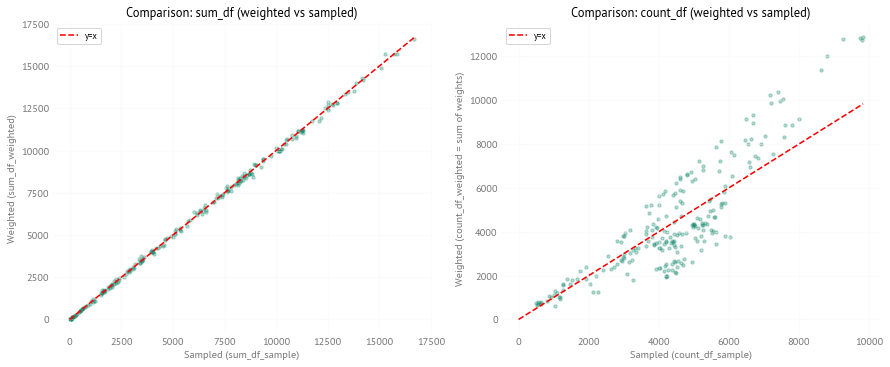

In [39]:
# Visual comparison: scatter plot of weighted vs sampled
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Compare sum_df
axes[0].scatter(comparison_sum['sampled'], comparison_sum['weighted'], alpha=0.3, s=10)
axes[0].plot([0, comparison_sum['sampled'].max()], [0, comparison_sum['sampled'].max()], 
             'r--', label='y=x')
axes[0].set_xlabel('Sampled (sum_df_sample)')
axes[0].set_ylabel('Weighted (sum_df_weighted)')
axes[0].set_title('Comparison: sum_df (weighted vs sampled)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compare count_df
axes[1].scatter(comparison_count['sampled'], comparison_count['weighted'], alpha=0.3, s=10)
axes[1].plot([0, comparison_count['sampled'].max()], [0, comparison_count['sampled'].max()], 
             'r--', label='y=x')
axes[1].set_xlabel('Sampled (count_df_sample)')
axes[1].set_ylabel('Weighted (count_df_weighted = sum of weights)')
axes[1].set_title('Comparison: count_df (weighted vs sampled)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [40]:
# Compare mean parity (sum/count) for both methods
mean_parity_weighted = sum_df_weighted / count_df_weighted
mean_parity_sampled = sum_df_sample / count_df_sample

comparison_mean = pd.DataFrame({
    'weighted': mean_parity_weighted.values.flatten(),
    'sampled': mean_parity_sampled.values.flatten()
})

# Remove NaN and zeros
comparison_mean = comparison_mean.dropna()
comparison_mean = comparison_mean[(comparison_mean['weighted'] > 0) | (comparison_mean['sampled'] > 0)]

print("Comparison of mean parity (sum/count):")
print(f"Number of valid entries: {len(comparison_mean)}")
print(f"\nSummary statistics:")
print(comparison_mean.describe())
print(f"\nCorrelation: {comparison_mean['weighted'].corr(comparison_mean['sampled']):.4f}")
print(f"\nMean absolute difference: {abs(comparison_mean['weighted'] - comparison_mean['sampled']).mean():.4f}")

Comparison of mean parity (sum/count):
Number of valid entries: 220

Summary statistics:
         weighted     sampled
count  220.000000  220.000000
mean     1.489280    1.452004
std      0.913590    0.923353
min      0.003651    0.004764
25%      0.705493    0.632749
50%      1.693288    1.661609
75%      2.149657    1.990718
max      3.472378    3.245253

Correlation: 0.8543

Mean absolute difference: 0.3519


Now we can select which version of the data to use for the model.

The results with the resampled data are more plausible, and they don't vary much from one sampling to another.
So that's what I'm using for now.

In [41]:
sum_df = sum_df_unweighted
count_df = count_df_unweighted

In [42]:
sum_df = sum_df_weighted
count_df = count_df_weighted

In [43]:
sum_df = sum_df_sample
count_df = count_df_sample

In [44]:
sum_df.head(10)

age_group,15.0,18.0,21.0,24.0,27.0,30.0,33.0,36.0,39.0,42.0,45.0,48.0,51.0,54.0
birth_group,,,,,,,,,,,,,,
1922.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4910.0
1925.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5325.0,11232.0
1928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9285.0,11285.0,14144.0
1931.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9354.0,12505.0,15093.0,1574.0
1934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8743.0,12939.0,13884.0,2051.0,1490.0
1937.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9040.0,12946.0,14212.0,1671.0,1597.0,2936.0
1940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888.0,12713.0,15268.0,3498.0,1561.0,3371.0,3421.0
1943.0,NaN,NaN,NaN,NaN,NaN,NaN,8588.0,12780.0,16703.0,10770.0,6991.0,3430.0,3426.0,1648.0
1946.0,NaN,NaN,NaN,NaN,NaN,7439.0,11747.0,15698.0,10787.0,12524.0,3492.0,3586.0,1869.0,0.0


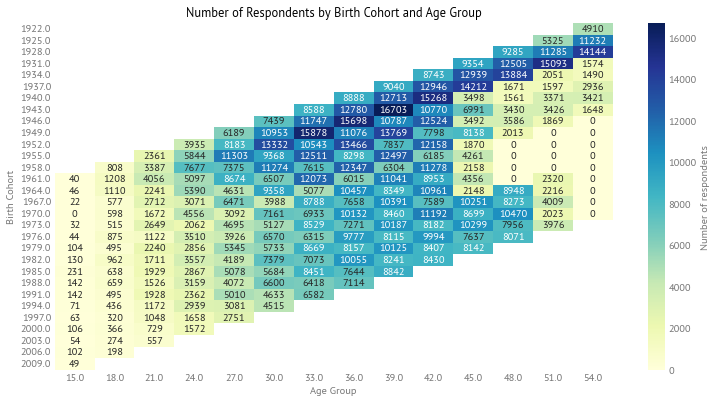

In [45]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    sum_df,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    cbar_kws={"label": "Number of respondents"},
)

plt.title("Number of Respondents by Birth Cohort and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Birth Cohort")
plt.grid(False)

In [46]:
count_df.head(30)

age_group,15.0,18.0,21.0,24.0,27.0,30.0,33.0,36.0,39.0,42.0,45.0,48.0,51.0,54.0
birth_group,,,,,,,,,,,,,,
1922.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1747.0
1925.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1916.0,3767.0
1928.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3010.0,3642.0,4805.0
1931.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2991.0,4006.0,4920.0,498.0
1934.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2811.0,4123.0,4492.0,632.0,533.0
1937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3026.0,4166.0,4807.0,559.0,561.0,1052.0
1940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3168.0,4618.0,5627.0,1254.0,600.0,1258.0,1268.0
1943.0,0.0,0.0,0.0,0.0,0.0,0.0,3728.0,5148.0,6677.0,4407.0,2919.0,1391.0,1465.0,651.0
1946.0,0.0,0.0,0.0,0.0,0.0,4018.0,5783.0,7469.0,4948.0,5708.0,1530.0,1658.0,801.0,0.0


In [47]:
sum_df / count_df

age_group,15.0,18.0,21.0,24.0,27.0,30.0,33.0,36.0,39.0,42.0,45.0,48.0,51.0,54.0
birth_group,,,,,,,,,,,,,,
1922.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.810532
1925.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.779228,2.981683
1928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.084718,3.098572,2.943600
1931.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.127382,3.121568,3.067683,3.160643
1934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.110281,3.138249,3.090828,3.245253,2.795497
1937.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.987442,3.107537,2.956522,2.989267,2.846702,2.790875
1940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.805556,2.752923,2.713346,2.789474,2.601667,2.679650,2.697950
1943.0,NaN,NaN,NaN,NaN,NaN,NaN,2.303648,2.482517,2.501573,2.443839,2.394998,2.465852,2.338567,2.531490
1946.0,NaN,NaN,NaN,NaN,NaN,1.851419,2.031299,2.101754,2.180073,2.194114,2.282353,2.162847,2.333333,NaN


I'll extract the age and cohort labels for use later in the notebook.

In [48]:
age_labels = sum_df.columns.astype(int).to_numpy()
cohort_labels = sum_df.index.astype(int).to_numpy()

## Save preprocessed data

Save the preprocessed data to HDF5 for use in the modeling notebook.

In [49]:
filename = "../data/fertility_cps_preprocessed.h5"

# Verify data types before saving
print(f"Data type check before saving:")
print(f"sum_df dtype: {sum_df.dtypes.unique()}")
print(f"count_df dtype: {count_df.dtypes.unique()}")
print(f"sum_df sample values (first 5x5):\n{sum_df.iloc[:5, :5]}")
print(f"count_df sample values (first 5x5):\n{count_df.iloc[:5, :5]}")
print(f"Are sum_df values integers? {sum_df.values.dtype.kind in ['i', 'u']}")
print(f"Are count_df values integers? {count_df.values.dtype.kind in ['i', 'u']}")

# Save the aggregated data
sum_df.to_hdf(filename, key='sum_df', mode='w')
count_df.to_hdf(filename, key='count_df', mode='a')
cfr_cps.to_hdf(filename, key='cfr_cps', mode='a')

# Save labels
pd.Series(age_labels).to_hdf(filename, key='age_labels', mode='a')
pd.Series(cohort_labels).to_hdf(filename, key='cohort_labels', mode='a')

# Save metadata
metadata = pd.Series({
    'cutoff_year': cutoff_year,
    'random_seed': 17,
    'timestamp': pd.Timestamp.now().isoformat()
})
metadata.to_hdf(filename, key='metadata', mode='a')

print(f"Saved preprocessed data to {filename}")

Data type check before saving:
sum_df dtype: [dtype('float64')]
count_df dtype: [dtype('float64')]
sum_df sample values (first 5x5):
age_group    15.0  18.0  21.0  24.0  27.0
birth_group                              
1922.0        NaN   NaN   NaN   NaN   NaN
1925.0        NaN   NaN   NaN   NaN   NaN
1928.0        NaN   NaN   NaN   NaN   NaN
1931.0        NaN   NaN   NaN   NaN   NaN
1934.0        NaN   NaN   NaN   NaN   NaN
count_df sample values (first 5x5):
age_group    15.0  18.0  21.0  24.0  27.0
birth_group                              
1922.0        0.0   0.0   0.0   0.0   0.0
1925.0        0.0   0.0   0.0   0.0   0.0
1928.0        0.0   0.0   0.0   0.0   0.0
1931.0        0.0   0.0   0.0   0.0   0.0
1934.0        0.0   0.0   0.0   0.0   0.0
Are sum_df values integers? False
Are count_df values integers? False
Saved preprocessed data to ../data/fertility_cps_preprocessed.h5


/tmp/ipykernel_264874/1517903309.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  metadata.to_hdf(filename, key='metadata', mode='a')


In [50]:
from utils import beep

beep()